In [27]:
%matplotlib inline

from __future__  import print_function, division

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

In [45]:
train = pd.read_csv('../data/Train_KQyJ5eh.csv', parse_dates=['Date'])
test = pd.read_csv('../data/Test_HmLwURQ.csv', parse_dates=['Date'])
sub = pd.read_csv('../data/Sample_Submission_6FjDs3p.csv')

## What is a Time Series Data ?

* Sequence of measurements across time.
* Over a continuous time interval.
* Equally spacing between every two consecutive measurements.
* With each time unit within the time interval hvaing at most one data point.


## Properties of Time Series

<img src="https://upload.wikimedia.org/wikipedia/commons/3/3e/SeasonalplotUS.png"/>
<p>Courtesy of Wikipedia</p>

** Seasonality **
>This pattern occurs when a series is influenced by seasonal factors. Seasonality is always of a fixed and of a known period.

<img src="http://www.es.lancs.ac.uk/cres/captain/airdata.jpg"/>
<p>http://www.es.lancs.ac.uk/cres/captain/dhrdemo.html</p>

** Trend **
> Trend exists when there is a long term increase or decrease in the data. It does not have to be linear. A trend can change direction and go from increasing to decreasing.

## Exploratory Data Analysis

In [46]:
# plot the data
train = train.set_index('Date', drop=False)

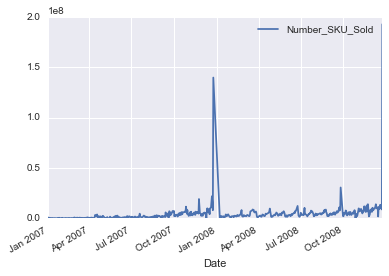

In [47]:
train[['Number_SKU_Sold']].plot();

** In order to better visualize the data, we can instead consider a log scale **

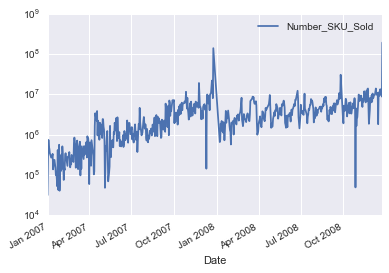

In [48]:
train[['Number_SKU_Sold']].plot(logy=True);

** You can see there is an upward trend. **

### Smoothing

>Smoothing is usually done to help us better see patterns, trends for example, in time series. For seasonal data, we might smooth out the seasonality so that we can identify the trend.  Smoothing doesn’t provide us with a model, but it can be a good first step in describing various components of the series.

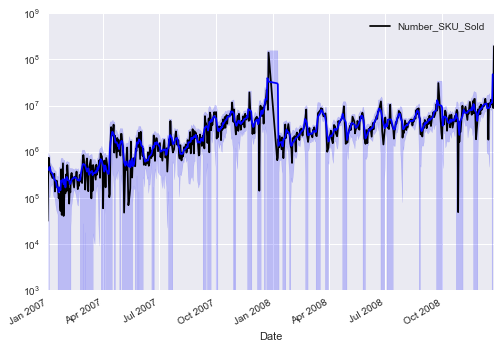

In [6]:
# consider mean
train_mean = pd.rolling_mean(train.Number_SKU_Sold, window=5, center=True)
train_std = pd.rolling_std(train.Number_SKU_Sold, window=5, center=True)

plt.figure()

train[['Number_SKU_Sold']].plot(c='k', logy=True)
train_mean.plot(logy=True, c='b')
plt.fill_between(train_std.index, train_mean-2*train_std, train_mean+2*train_std, color='b', alpha=0.2)
plt.yscale('log')
plt.show();

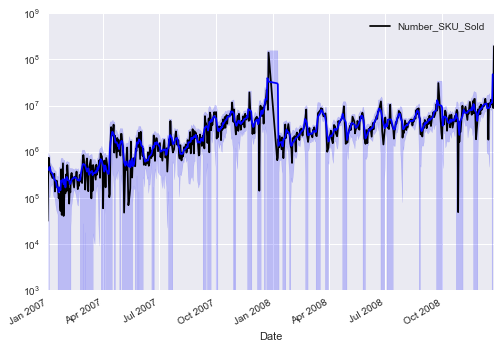

In [7]:
# consider median
train_median = pd.rolling_mean(train.Number_SKU_Sold, window=5, center=True)
train_std = pd.rolling_std(train.Number_SKU_Sold, window=5, center=True)

plt.figure()

train[['Number_SKU_Sold']].plot(c='k', logy=True)
train_median.plot(logy=True, c='b')
plt.fill_between(train_std.index, train_median-2*train_std, train_median+2*train_std, color='b', alpha=0.2)
plt.yscale('log')
plt.show();

## Autocorrelation

> Used to check for seasonality

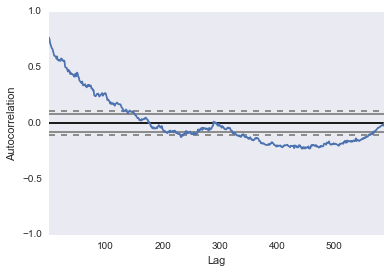

In [11]:
autocorrelation_plot(train.Number_SKU_Sold.map(np.log1p));

In [49]:
train.loc[:, 'month'] = train.Date.dt.month
test.loc[:, 'month'] = test.Date.dt.month

train.loc[:, 'year'] = train.Date.dt.year
test.loc[:, 'year'] = test.Date.dt.year

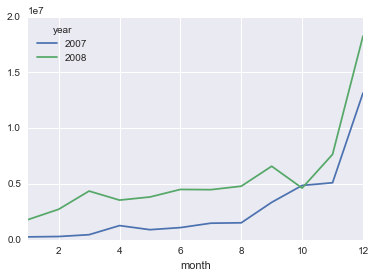

In [50]:
train.groupby(['year', 'month']).Number_SKU_Sold.mean().unstack(0).plot();

In [51]:
train.loc[:, 'weekday'] = train.Date.dt.weekday
test.loc[:, 'weekday'] = test.Date.dt.weekday

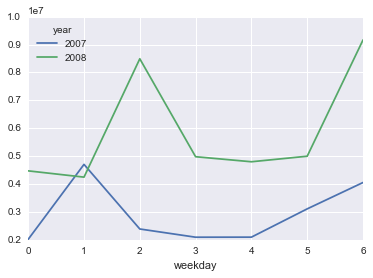

In [52]:
train.groupby(['year', 'weekday']).Number_SKU_Sold.mean().unstack(0).plot();

In [53]:
train.loc[:, 'quarter'] = train.Date.dt.quarter
test.loc[:, 'quarter'] = test.Date.dt.quarter

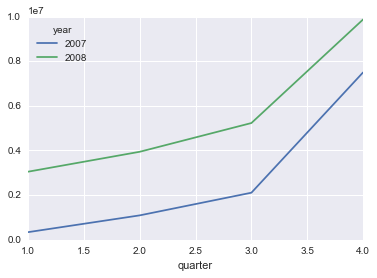

In [54]:
train.groupby(['year', 'quarter']).Number_SKU_Sold.mean().unstack(0).plot();

## Modelling

In [186]:
train['Number_SKU_Sold'] = train.Number_SKU_Sold.map(np.log1p)
train['Number_SKU_Sold'] = train.Number_SKU_Sold.astype(np.float)

In [270]:
arma_mod20 = sm.tsa.ARMA(train[['Number_SKU_Sold']], (15,5)).fit()
print(arma_mod20.params)

const                     15.178553
ar.L1.Number_SKU_Sold     -0.251998
ar.L2.Number_SKU_Sold      0.081357
ar.L3.Number_SKU_Sold      0.309455
ar.L4.Number_SKU_Sold      0.552173
ar.L5.Number_SKU_Sold      0.797314
ar.L6.Number_SKU_Sold     -0.278781
ar.L7.Number_SKU_Sold     -0.110796
ar.L8.Number_SKU_Sold     -0.035180
ar.L9.Number_SKU_Sold     -0.065491
ar.L10.Number_SKU_Sold    -0.123314
ar.L11.Number_SKU_Sold    -0.081685
ar.L12.Number_SKU_Sold    -0.052841
ar.L13.Number_SKU_Sold     0.064341
ar.L14.Number_SKU_Sold     0.048184
ar.L15.Number_SKU_Sold     0.141822
ma.L1.Number_SKU_Sold      0.575819
ma.L2.Number_SKU_Sold      0.307782
ma.L3.Number_SKU_Sold     -0.024965
ma.L4.Number_SKU_Sold     -0.409768
ma.L5.Number_SKU_Sold     -0.872638
dtype: float64


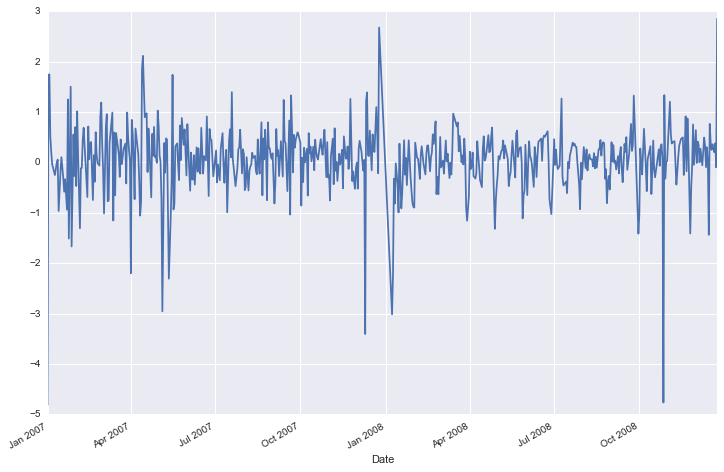

In [271]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod20.resid.plot(ax=ax);

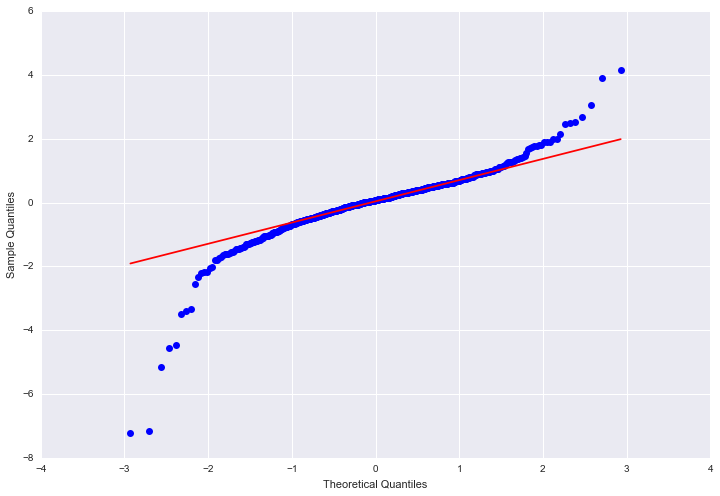

In [272]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(arma_mod20.resid, line='q', ax=ax, fit=True)

In [273]:
resid = arma_mod20.resid

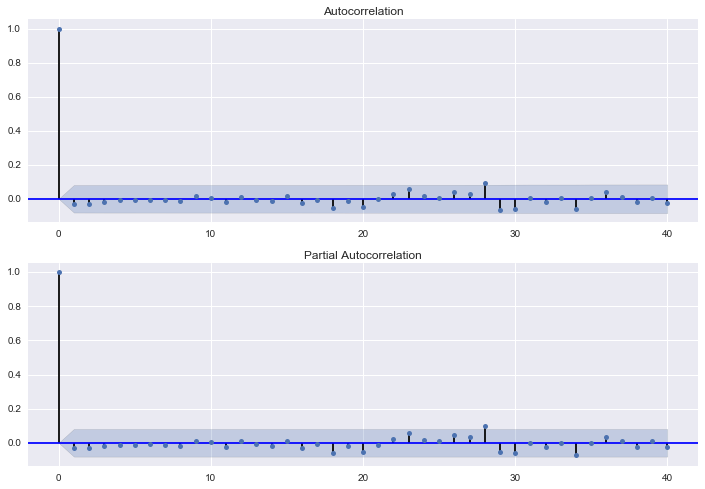

In [274]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [275]:
predict_sku_sold = arma_mod20.predict('2008-05-01', '2008-12-24', dynamic=True)
print(predict_sku_sold)

Date
2008-05-01    14.538242
2008-05-02    14.676159
2008-05-03    14.832993
2008-05-05    14.890004
2008-05-06    14.570773
2008-05-07    14.638132
2008-05-08    14.828498
2008-05-09    14.983076
2008-05-12    14.926204
2008-05-13    14.880600
2008-05-14    15.054389
2008-05-15    15.168140
2008-05-16    14.866496
2008-05-17    14.905000
2008-05-19    14.976054
2008-05-20    15.141121
2008-05-21    15.008513
2008-05-22    14.778745
2008-05-23    14.996599
2008-05-24    15.009393
2008-05-25    15.004236
2008-05-26    14.810875
2008-05-27    14.848865
2008-05-28    15.085814
2008-05-29    14.948547
2008-05-30    14.874881
2008-05-31    14.833004
2008-06-02    14.990062
2008-06-03    15.066000
2008-06-04    14.835701
                ...    
2008-11-21    14.992105
2008-11-22    14.970724
2008-11-23    14.971781
2008-11-25    14.970145
2008-11-26    14.988523
2008-11-27    14.984148
2008-11-28    14.963010
2008-11-29    14.978357
2008-12-01    14.981281
2008-12-02    14.987367
2008-12-03 

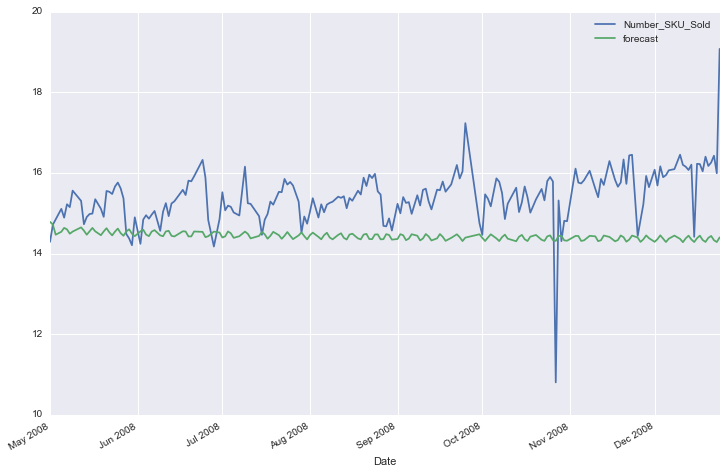

In [269]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = train.ix['2008-05-01':][['Number_SKU_Sold']].plot(ax=ax)
fig = arma_mod20.plot_predict('2008-05-01', '2008-12-24', dynamic=True, ax=ax, plot_insample=False)

In [255]:
def split_dataset(df, time_threshold):
    """
    Splits the dataset based on a time reference where all values less than reference point would
    constitute training set and rest would be test set.
    
    Args:
        df: dataframe
        time_threshold: time reference
    Return:
        train: Training examples
        test: Test examples
    """
    
    train = df[df.Date <= time_threshold]
    test = df[df.Date > time_threshold]
    
    return (train, test)